### Developer: Mayana Mohsin Khan

## Implement a SGD Algorithm with Ridge Regression

In [9]:
# Loading packages
library(reshape2)
library(ggplot2)
library(glmnet)

In [10]:
##--- Stochastic Gradient Descent --------------------------------------------
sgd_train <- function(train_x, train_y, lambda, eta, epsilon, max_epoch) {
    
   train_len = dim(train_x)[1]
   tau_max = max_epoch * train_len
   
   # matrix to store the weights 
   W <- matrix(,nrow=tau_max, ncol=ncol(train_x)) 
   W[1,] <- runif(ncol(train_x))
  
    
   tau = 1 # counter 
   obj_func_val <-matrix(,nrow=tau_max, ncol=1) 
   obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)

   # SGD loop 
   while (tau <= tau_max){

       # check termination criteria
       if (obj_func_val[tau,1]<=epsilon) {break}
 
       # shuffle data:
       train_index <- sample(1:train_len, train_len, replace = FALSE)
    
       # loop over each datapoint
       for (i in train_index) {
           # increment the counter
           tau <- tau + 1
           if (tau > tau_max) {break}

           # make the weight update
           y_pred <- predict_func(train_x[i,], W[tau-1,])
           W[tau,] <- sgd_update_weight(W[tau-1,], train_x[i,], train_y[i], y_pred, lambda, eta)

           # keep track of the objective funtion
           obj_func_val[tau,1] = train_obj_func(train_x, W[tau,],train_y, lambda)
       }
   }
   # resulting values for the training objective function as well as the weights
   return(list('vals'=obj_func_val,'W'=W))
}

### III. Study the effects of L2 Normalization
### A. Loading the Data set

In [11]:
# reading the data
read_data <- function(fname, sc) {
   data <- read.csv(file=fname,head=TRUE,sep=",")
   nr = dim(data)[1]
   nc = dim(data)[2]
   x = data[1:nr,1:(nc-1)]
   y = data[1:nr,nc]
   if (isTRUE(sc)) {
      x = scale(x)
      y = scale(y)
   }
   return (list("x" = x, "y" = y))
}

### B. For each lambda in {0, 0.4, 0.8, …, 10}, build a regression model and compute the training and testing errors, using the provided datasets. While building each model, all parameter settings (initial values, learning rate, etc) are exactly the same, except a lambda value. Set the termination criterion as maximum of 20 x N weight updates (where N is the number of training data). Create a plot of error rates (use different colors for the training and testing errors), where the x-axis is log lambda and y-axis is the error rate. 

In [12]:
# auxiliary function to calculate labels based on the estimated coefficients
predict_func <- function(Phi, w){
    return(Phi%*%w)
} 

In [13]:
# auxiliary function to calculate the objective function for the training
train_obj_func <- function (Phi, w, label, lambda){
    # the L2 regulariser is already included in the objective function for training
    return(mean((predict_func(Phi, w) - label)^2) + .5 * lambda * w %*% w)
}

In [14]:
# auxiliary function to compute the error of the model
get_errors <- function(train_data, test_data, W) {
   n_weights = dim(W)[1]
   errors = matrix(,nrow=n_weights, ncol=2)
   for (tau in 1:n_weights) {
      errors[tau,1] = train_obj_func(train_data$x, W[tau,],train_data$y, 0)
      errors[tau,2] = train_obj_func(test_data$x, W[tau,],test_data$y, 0)
   }
   return(errors)
}

In [15]:
# updating the weight vector
sgd_update_weight <- function(W_prev, x, y_true, y_pred, lambda, eta) {
   # MODIFY THIS FUNCTION FOr L2 REG
   grad = - (c(y_true) - c(y_pred)) * x + lambda * W_prev
   W_new = (W_prev - eta * grad) 
   return(W_new)
}

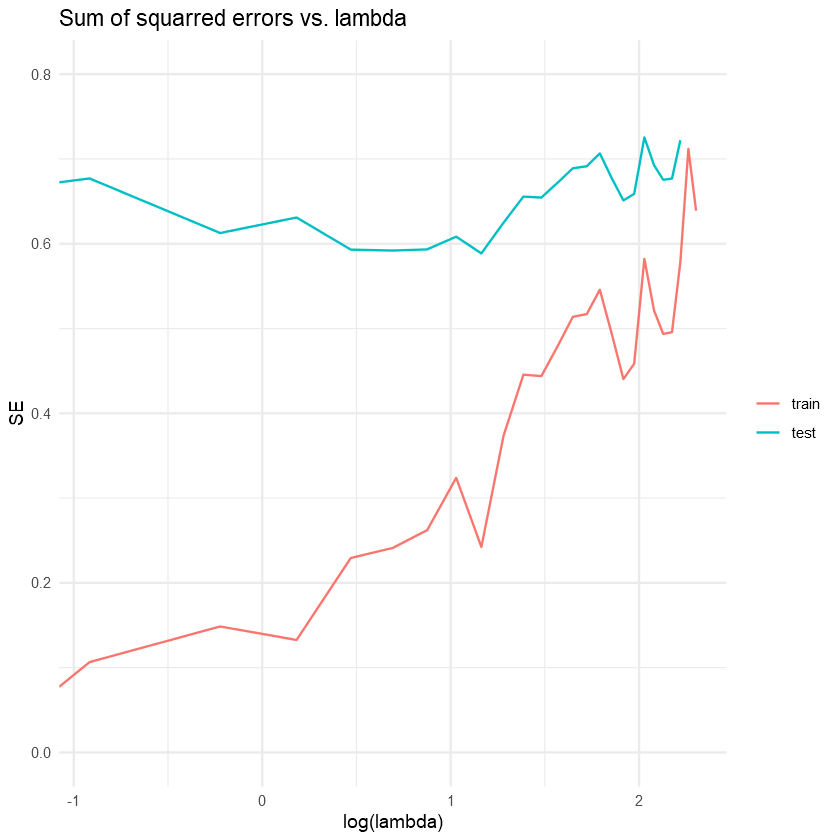

In [16]:
##------------------------------------------------------------------------
play_with_sgd <- function() {
   ## reading the data
   dtrain = read_data("Task1C_train.csv", TRUE)
   dtest = read_data("Task1C_test.csv", TRUE)
 
   ##### SGD Trainng
   max_epoch = 20
   epsilon = .001
   eta = .01
   lambda = seq(0,10,0.4)
    
   errors = matrix(0,nrow=length(lambda), ncol=3)
   
   #loop using index of lambdas
   for(l in 1:length(lambda)){
       curlm = lambda[l]
       train_res = sgd_train(dtrain$x, dtrain$y, curlm, eta, epsilon, max_epoch)
       n = dim(train_res$W)[1]
       error = get_errors(dtrain, dtest,t(as.matrix(train_res$W[n,])))
       errors[l,1] = curlm
       errors[l,2] = error[,1]
       errors[l,3] = error[,2]
   } 
   error.df = as.data.frame(errors)
   names(error.df) <- c('lambda', 'train', 'test') 
    
   error.m <- melt(error.df, id='lambda')
   names(error.m) <- c('lambda', 'set', 'SE') 
 
   #plot sum of squarred error for train and test sets vs lambda 
   g <- ggplot(data = error.m, aes(x= log(lambda), y = SE, color = factor(set))) + geom_line() +  ylim(0,0.8) +
        scale_color_discrete(guide = guide_legend(title = NULL)) + 
        ggtitle('Sum of squarred errors vs. lambda') + theme_minimal()
   print(g) 
}

# playing with the SGD 
play_with_sgd() 

### C. Based on your plot in the previous part (Part b), what’s the best value for lambda? Discuss lambda, model complexity, and error rates, corresponding to underfitting and overfitting, by observing your plot. 

##### ANSWER:
* For training sample, the best value is `-1`.
* for testing samples, the best value of lambda is `0.9`

* If the lambda value is large, then its over fitting the data. in the plot above, the training sample is over fitter compared to the testing sample.
*  If the lambda value is small, then its under fitting the data. in the plot above, the testing sample is under fitter compared to the testing sample.

* since the testing set underfiited model, it has higher SE compared to training sample.